## PreProcess Images and feed into CNN

In [36]:
# Mount Google Drice
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!pip install pyrsgis

In [0]:
!git clone https://github.com/maxjonasbehrens/master_thesis_code
#%cd /content/master_thesis_code
#!git pull

Cloning into 'master_thesis_code'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 246 (delta 126), reused 178 (delta 78), pack-reused 0
Receiving objects: 100% (246/246), 559.54 KiB | 817.00 KiB/s, done.
Resolving deltas: 100% (126/126), done.


In [0]:
%load /content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io
import sklearn.model_selection

In [0]:
# Import own module to preprocess images
import imp
sat_images = imp.new_module('sat_images')
exec(open("/content/master_thesis_code/NeuralNetTrain/imgProcessing/sat_images.py").read(), sat_images.__dict__)

## Test for one image

In [0]:
# Download test image from drive
img_path = "/gdrive/My Drive/nuts_night/BE34_2013.tif"

ds1, img = pyrsgis.raster.read(img_path)

In [0]:
# Print its shape
print("Image shape: ",img.shape)

Image shape:  (1299, 1482)


In [0]:
# Resize original image to compatible size
orig_img = np.swapaxes(img,0,-1)
orig_resized = resize(orig_img, (256,256))

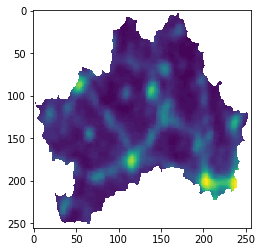

In [0]:
# Show the original image
plt.imshow(orig_resized, interpolation='nearest')
plt.show()

In [0]:
# Check the data frame
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/enhanced_gdp_data.csv")
y_dat.head()

,nuts2,year,nuts_value,code,country,country_value,mean_value,diff_value
0,BE10,2008,61100.0,BE,Belgium,33100.0,31881.818182,28000.0
1,BE21,2008,39200.0,BE,Belgium,33100.0,31881.818182,6100.0
2,BE22,2008,27500.0,BE,Belgium,33100.0,31881.818182,-5600.0
3,BE23,2008,29400.0,BE,Belgium,33100.0,31881.818182,-3700.0
4,BE24,2008,34500.0,BE,Belgium,33100.0,31881.818182,1400.0


In [0]:
mae_diff = np.mean(abs(y_dat['diff_value']-y_dat['diff_value'].mean()))
print(mae_diff)

5478.004371660496


In [0]:
# List of all files in directory
mypath = "/gdrive/My Drive/nuts_night/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [0]:
# PreProcess images with certain resolution
res = 512
x,y,label = sat_images.create_data(onlyfiles,mypath,y_dat,prediction='diff_value',resolution=res,night=True)

Image processed:  0  of  692
Image processed:  10  of  692
Image processed:  30  of  692
Image processed:  40  of  692
Image processed:  50  of  692
Image processed:  60  of  692
Image processed:  70  of  692
Image processed:  80  of  692
Image processed:  90  of  692
Image processed:  100  of  692
Image processed:  110  of  692
Image processed:  120  of  692
Image processed:  130  of  692
Image processed:  140  of  692
Image processed:  150  of  692
Image processed:  160  of  692
Image processed:  170  of  692
Image processed:  180  of  692
Image processed:  190  of  692
Image processed:  200  of  692
Image processed:  210  of  692
Image processed:  220  of  692
Image processed:  230  of  692
Image processed:  240  of  692
Image processed:  250  of  692
Image processed:  260  of  692
Image processed:  270  of  692
Image processed:  280  of  692
Image processed:  290  of  692
Image processed:  300  of  692
Image processed:  310  of  692
Image processed:  320  of  692
Image processed:  

In [0]:
# Save ndarray to reproduce
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_night_orig_512.mat", mdict={'x': x}, oned_as='row')

In [0]:
# Load input from scratch
#x = np.vstack((scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_orig_512_1.mat")['x'],scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_day_orig_512_2.mat")['x']))
x = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_night_orig_512.mat")['x']
y, label = sat_images.create_y_label(onlyfiles,mypath,y_dat,prediction='nuts_value')

In [0]:
# Print shape of images
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  692
Shape of y:  692
Shape of labels:  692


## Create Train and Test Sets

In [0]:
# Create list of unique regions
regions = []
for i in range(len(label)):
  regions.append(label[i].rsplit('_',1)[0])

regions = np.unique(regions)
print(len(regions))

117


In [0]:
# Split regions into train and test set
msk_test = np.random.rand(len(regions)) < 0.2

train_split = regions[~msk_test]
test_split = regions[msk_test]

msk_val = np.random.rand(len(train_split)) < 0.25

val_split = train_split[msk_val]
train_split = train_split[~msk_val]
print(len(train_split))
print(len(val_split))
print(len(test_split))

77
17
23


In [47]:
# Split whole data set into test and train based on split regions
import math
label_train = []
label_val = []
label_test = []
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

# Split into train and test based on previous region split
for i in range(len(label)):
  if label[i].rsplit('_',1)[0] in train_split:
    if math.isnan(y[i]):
      pass
    else:
      label_train.append(label[i])
      x_train.append(x[i])
      y_train.append(int(y[i]))
  elif label[i].rsplit('_',1)[0] in val_split:
    if math.isnan(y[i]):
      pass
    else:
      label_val.append(label[i])
      x_val.append(x[i])
      y_val.append(int(y[i]))
  else:
    if math.isnan(y[i]):
      pass
    else:
      label_test.append(label[i])
      x_test.append(x[i])
      y_test.append(int(y[i]))

# Transform into numpy array
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)  
y_val = np.array(y_val)

# Print Shape
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)

(452, 512, 512)
(138, 512, 512)
(138,)
(102, 512, 512)


In [48]:
# Only execute when using night images, since they are 1d
x_train = np.array([x_train])
x_train = np.moveaxis(x_train,0,-1)
print(x_train.shape)
x_val = np.array([x_val])
x_val = np.moveaxis(x_val,0,-1)
print(x_val.shape)
x_test = np.array([x_test])
x_test = np.moveaxis(x_test,0,-1)
print(x_test.shape)

(452, 512, 512, 1)
(102, 512, 512, 1)
(138, 512, 512, 1)


In [49]:
# Normalise the data
x_train = (x_train/np.max(x_train))
x_test = (x_test/np.max(x_test))
x_val = (x_val/np.max(x_val))
print(np.max(x_train))

1.0


In [0]:
# Deep Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=(512,512,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

#model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

#model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

In [0]:
# Transfer Learning
base_model = tf.keras.applications.MobileNet(input_shape=(512,512,3),include_top=False)
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(units=1, activation = 'linear')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [0]:
# Data Augmentation
training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# Data Preparation
batch_size = 10

# Define the data flow
training_generator = training_data_generator.flow(x_train,y_train,batch_size=batch_size)
validation_generator = validation_data_generator.flow(x_val, y_val,batch_size=batch_size)
test_generator = test_data_generator.flow(x_test,y_test,batch_size=1,shuffle=False)

In [54]:
# Calculate the number of steps
training_steps = training_generator.n/batch_size
validation_steps = validation_generator.n/batch_size

# Run the model
model.fit_generator(training_generator,
                    steps_per_epoch=training_steps,
                    epochs = 50,
                    validation_data = validation_generator,
                    validation_steps = validation_steps,
                    verbose = 1
                   )

Epoch 1/50
46/45 [==============================] - 13s 291ms/step - loss: 253140818.1926 - mean_squared_error: 257064128.0000 - mean_absolute_error: 12017.5977 - val_loss: 408033956.0784 - val_mean_squared_error: 380903264.0000 - val_mean_absolute_error: 16785.6660
Epoch 2/50
46/45 [==============================] - 7s 155ms/step - loss: 153941446.6728 - mean_squared_error: 150033008.0000 - mean_absolute_error: 8807.9658 - val_loss: 237079398.4314 - val_mean_squared_error: 223320208.0000 - val_mean_absolute_error: 12180.6934
Epoch 3/50
46/45 [==============================] - 7s 155ms/step - loss: 117298861.5963 - mean_squared_error: 115132600.0000 - mean_absolute_error: 8207.7529 - val_loss: 197119701.1765 - val_mean_squared_error: 189428320.0000 - val_mean_absolute_error: 11277.7500
Epoch 4/50
46/45 [==============================] - 7s 155ms/step - loss: 73837207.2494 - mean_squared_error: 75064584.0000 - mean_absolute_error: 6613.2339 - val_loss: 251613883.1373 - val_mean_squared_

In [55]:
# Calculate the test performance
test_score = model.evaluate_generator(test_generator)
print('Test loss: '+str(test_score[0]))
print('Test MSE: '+str(test_score[1]))
print('Test MAE: '+str(test_score[2]))

Test loss: 186862245.7321291
Test MSE: 186862270.0
Test MAE: 9718.86
